## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import wordcloud as wc
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import lightgbm as lgb

## Data reading

In [2]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong. Please, check file path.')

In [3]:
display(df.head(10))
display(df.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

## Lemmatization

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonvezde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Custom class capable of lemmatizing column of a dataframe

In [5]:
class LemmatizeColumn:    
    def __init__(self, dataframe, column_name):
        assert isinstance(column_name, str), 'Column name should be type(str)'
        assert isinstance(dataframe, pd.DataFrame), 'Dataframe should be type(pd.DataFrame)'
        self.df = dataframe
        self.col = column_name
        self.train_X_default = self.df[self.col]
        
    def get_lemmas(self):
        self.train_X = []
        for i in range(0, len(self.train_X_default)):
            self.review = re.sub('[^a-zA-Z]', ' ', self.train_X_default[i])
            self.review = self.review.lower()
            self.review = self.review.split()
            self.review = [lemmatizer.lemmatize(self.word) for self.word in self.review 
                           if not self.word in set(stopwords)]
            self.review = ' '.join(self.review)
            self.train_X.append(self.review)            
        return self.train_X
        
    def get_lemmatized_df(self):
        return pd.DataFrame(self.get_lemmas(), index=self.df.index, columns=['text_lemmatized'])
    
    def get_complete_df(self):
        return pd.concat([self.df, self.get_lemmatized_df()], axis=1)     

### Result of a lemmatized column

In [6]:
lemma = LemmatizeColumn(df, column_name='text')

In [7]:
df_lemma = lemma.get_complete_df()

In [8]:
df_lemma.head(10)

,text,toxic,text_lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intending...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


### WordCloud

In [9]:
text = ' '.join(df_lemma['text_lemmatized'].to_list())

In [10]:
wordcloud = wc.WordCloud(background_color ='white',
                         width=2000,height=900,
                         min_font_size = 5,
                         max_words=100).generate(text)

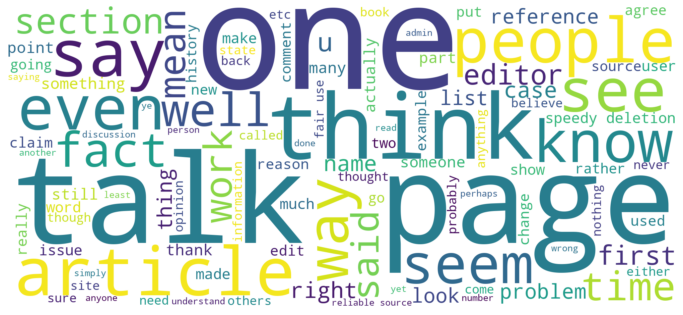

In [11]:
plt.figure(figsize = (12, 7), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data splitting

In [12]:
X = df_lemma['text_lemmatized']
y = df_lemma['toxic']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=0)

## TF-IDF

In [14]:
tf_idf = TfidfVectorizer(stop_words=stopwords, min_df=0)
X_train_scaled = tf_idf.fit_transform(X_train)
X_test_scaled = tf_idf.transform(X_test)

In [15]:
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(119678, 133558) (119678,)
(39893, 133558) (39893,)


## Data scaling

In [16]:
scaler = MaxAbsScaler()
scaler.fit(X_train_scaled)
X_train_scaled_max = scaler.transform(X_train_scaled)
X_test_scaled_max = scaler.transform(X_test_scaled)

## LogisticRegression

In [17]:
model1 = LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)
model1.fit(X_train_scaled_max, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [18]:
pred1 = model1.predict(X_test_scaled_max)
score1 = f1_score(y_test, pred1)
round(score1, 4)

0.7568

## LightGBM (no hyperparameter tuning)

In [19]:
model2 = lgb.LGBMClassifier(is_unbalance=True, n_jobs=-1)
model2.fit(X_train_scaled_max, y_train)

LGBMClassifier(is_unbalance=True)

In [20]:
pred2 = model2.predict(X_test_scaled_max)
score2 = f1_score(y_test, pred2)
round(score2, 4)

0.7356

## LightGBM (hyperparameter tuning)

In [21]:
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'f1-score', 'is_unbalance': True}

grid_params = {'learning_rate': [0.1], 'n_estimators': [8, 24, 32],
               'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
               'objective': ['binary'], 'seed': [500], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
               'reg_lambda': [1, 2, 6]}

mod = lgb.LGBMClassifier(**params)

In [22]:
mod.get_params().keys()
grid = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train_scaled_max, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 24, 'num_leaves': 6, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 6, 'seed': 500, 'subsample': 0.75}
0.9358445046589403


In [23]:
pred3 = grid.predict(X_test_scaled_max)
score3 = f1_score(y_test, pred3)
round(score3, 4)

0.5841

## Conclusion

Best model: LogisticRegression.  
f1-score: 0.7536